In [1]:
import ROOT
import pandas
import numpy as np
np.random.seed(1234)

filename = "BDTNoMFakes.root"
# Specify variables which shall be used as input for the neural network
variables = ["mPt", "tPt", "dPhiMuTau", "dEtaMuTau", "type1_pfMetEt", "m_t_collinearMass", "MTTauMET", "dPhiTauMET"]

def load_tree(filename, treename):
    f = ROOT.TFile(filename)
    t = f.Get(treename)
    data, labels = t.AsMatrix(columns=variables + ["weight"], return_labels=True)
    return pandas.DataFrame(data=data, columns=labels)

# Load data from ROOT TTrees to panda dataframes
signal = load_tree(filename, "TreeS")
background = load_tree(filename, "TreeB")

# Show the content of a dataframe
#print(background)
print(signal)

Welcome to JupyROOT 6.14/04
               mPt         tPt  dPhiMuTau  dEtaMuTau  type1_pfMetEt  \
0       127.534698   40.857040   1.874537   0.299006      29.954220   
1        55.673016   64.135803   3.103957   0.001630      17.638336   
2        61.965294   41.170265   2.665531   0.430505      35.479137   
3        65.102623   34.385368   2.709900   0.952318      17.245623   
4        64.027489   34.864071   2.968166   0.472034      26.082758   
5        47.004307   43.467762   2.109716   1.605180      18.687693   
6        56.403778   35.984436   2.696020   0.147612      13.599823   
7        49.785145   41.456894   2.963447   1.150193      26.616776   
8        65.448242   36.881042   3.137848   0.340434      72.160683   
9        39.681168   63.421822   2.790266   0.699730      62.765610   
10       54.367619   50.109386   3.077994   0.494990      11.886500   
11       86.899460   43.689690   1.651395   1.272874      27.529051   
12       76.045921   32.038799   2.818599   0.576

In [2]:
# Sum of all event weights is needed for reweighting to equal importance
sum_weights = np.sum(signal["weight"]) + np.sum(background["weight"])

# Function to reweight the weights to equal importance
def reweight(df):
    df["weight_reweighted"] = df["weight"] * sum_weights / np.sum(df["weight"])

# Run the reweighting on the pandas dataframe
reweight(signal)
reweight(background)

In [3]:
import matplotlib.pyplot as plt

# Function to plot a variable
def plot(variable):
    plt.figure()
    range_ = np.percentile(signal[variable], (5, 95))
    plt.hist(
        [signal[variable], background[variable]],
        range=range_,
        #bins=30,
        weights=[
            signal["weight_reweighted"],
            background["weight_reweighted"]],
        histtype="step",
        lw=2,
        label=("signal", "background"))
    plt.xlabel(variable)
    plt.legend()

# Loop over variables and plot each one
for var in variables:
    plot(var)

In [4]:
# Function to extract numpy array from pandas dataframe
def load_data(df, index):
    x = df.as_matrix(columns=variables)
    w = df.as_matrix(columns=["weight_reweighted"])
    y = np.zeros((x.shape[0], 2))
    y[:, index] = 1
    return x, w, y

# Load data from dataframe to numpy arrays
signal_x, signal_w, signal_y = load_data(signal, 0)
background_x, background_w, background_y = load_data(background, 1)

# Stack numpy arrays of different processes to single array
x = np.vstack([signal_x, background_x])
w = np.vstack([signal_w, background_w]).squeeze()
y = np.vstack([signal_y, background_y])

# Print what we are doing
print("Variables:\n{}\n".format(variables))
print("Inputs:\n{}\n".format(x))
print("Weights:\n{}\n".format(w))
print("Targets:\n{}\n".format(y))

/cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Variables:
['mPt', 'tPt', 'dPhiMuTau', 'dEtaMuTau', 'type1_pfMetEt', 'm_t_collinearMass', 'MTTauMET', 'dPhiTauMET']

Inputs:
[[127.53469849  40.85704041   1.87453699 ... 152.64982605  15.37453747
    0.44124684]
 [ 55.67301559  64.13580322   3.10395694 ... 127.07994843  34.40900421
    1.07390487]
 [ 61.96529388  41.1702652    2.6655314  ... 135.64813232  12.23861694
    0.31965429]
 ...
 [ 40.33189774  35.78040695   3.02741408 ... 121.95365143  21.02047729
    0.67051148]
 [ 77.53773499  57.17890167   3.02356911 ... 279.15966797  17.92713547
    0.28126413]
 [ 63.64655304  46.12130356   2.84808707 ... 155.3684845   46.97984314
    0.96187961]]

Weights:
[0.45062723 0.44411982 0.44874654 ... 0.36436901 0.36436901 0.2758794 ]

Targets:
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]



In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Stack layers defining neural network architecture
model = Sequential()
model.add(Dense(100, activation="relu", input_dim=len(variables)))
model.add(Dropout(0.2))
model.add(Dense(2, activation="softmax"))

# Specify loss function and optimizer algorithm
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

# Print architecture
model.summary()

Using Theano backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               900       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 1,102
Trainable params: 1,102
Non-trainable params: 0
_________________________________________________________________


In [6]:
from sklearn.model_selection import train_test_split

# Split dataset in training and validation part used for the gradient steps and monitoring of the training
x_train, x_val, y_train, y_val, w_train, w_val = train_test_split(x, y, w, test_size=0.5, random_state=1234)

# Train the neural network
history = model.fit(
                x_train, y_train,
                sample_weight=w_train,
                batch_size=1000,
                epochs=50,
                validation_data=(x_val, y_val, w_val))

Train on 174626 samples, validate on 174627 samples
Epoch 1/50
174626/174626 [==============================] - 3s 15us/step - loss: 0.6376 - acc: 0.6433 - val_loss: 0.1494 - val_acc: 0.7710
Epoch 2/50
174626/174626 [==============================] - 3s 15us/step - loss: 0.1629 - acc: 0.7208 - val_loss: 0.1362 - val_acc: 0.7695
Epoch 3/50
174626/174626 [==============================] - 3s 14us/step - loss: 0.1404 - acc: 0.7605 - val_loss: 0.1311 - val_acc: 0.8001
Epoch 4/50
174626/174626 [==============================] - 3s 14us/step - loss: 0.1329 - acc: 0.7816 - val_loss: 0.1245 - val_acc: 0.7954
Epoch 5/50
174626/174626 [==============================] - 3s 14us/step - loss: 0.1273 - acc: 0.7961 - val_loss: 0.1213 - val_acc: 0.8185
Epoch 6/50
174626/174626 [==============================] - 3s 14us/step - loss: 0.1243 - acc: 0.8024 - val_loss: 0.1192 - val_acc: 0.8233
Epoch 7/50
174626/174626 [==============================] - 3s 15us/step - loss: 0.1219 - acc: 0.8080 - val_loss: 

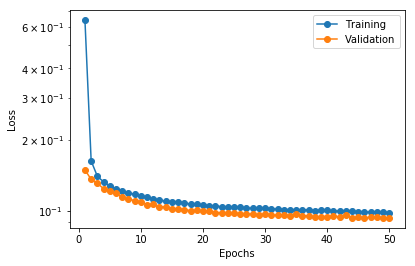

In [7]:
# Extract number of run epochs from the training history
epochs = range(1, len(history.history["loss"])+1)

# Extract loss on training and validation dataset and plot them together
plt.plot(epochs, history.history["loss"], "o-", label="Training")
plt.plot(epochs, history.history["val_loss"], "o-", label="Validation")
plt.xlabel("Epochs"), plt.ylabel("Loss")
plt.yscale("log")
plt.legend();

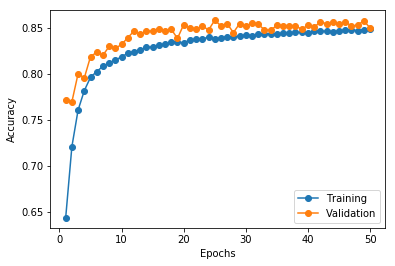

In [8]:
# Extract number of run epochs from the training history
epochs = range(1, len(history.history["loss"])+1)

# Extract accuracy on training and validation dataset and plot them together
plt.plot(epochs, history.history["acc"], "o-", label="Training")
plt.plot(epochs, history.history["val_acc"], "o-", label="Validation")
plt.xlabel("Epochs"), plt.ylabel("Accuracy")
plt.legend();

In [9]:
# Get neural network prediction for each MC sample
signal_predictions = model.predict(signal_x)
background_predictions = model.predict(background_x)

# Print predictions showing probability for each process
print("Predictions of signal events:\n{}\n".format(
    signal_predictions))
print("Mean probability per process:\n{}\n".format(
    np.mean(signal_predictions, axis=0)))

Predictions of signal events:
[[0.83349377 0.16650622]
 [0.9363054  0.06369457]
 [0.87061185 0.12938817]
 ...
 [0.86405987 0.13594012]
 [0.74325925 0.25674075]
 [0.85633594 0.14366405]]

Mean probability per process:
[0.74547684 0.25453907]



In [10]:
# These are our processes
processes = ["signal", "background"]

# Structure categories
categories = {}
for category in processes: # Make dedicated category for each process
    categories[category] = {}
    for process in processes: # Store NN scores and event weights of each process contributing to this category
        categories[category][process] = {"scores": [], "weights": []}

predictions = {
    "signal": signal_predictions,
    "background": background_predictions
}
weights = {
    "signal": signal["weight"],
    "background": background["weight"]
}

# Loop over processes
for i_process, process in enumerate(processes):
    # Loop over events of this process
    n_events = predictions[process].shape[0]
    for i_event in range(n_events):
        # Find category for this event and retrieve NN score
        p = predictions[process][i_event] # e.g., [0.3, 0.5, 0.2]
        max_index = np.argmax(p)          #             1
        max_score = p[max_index]          #             0.5
        category = processes[max_index]   #             "ztt"
        
        # Store NN score and event weight for this event in respective category
        categories[category][process]["scores"].append(
            max_score
        )
        categories[category][process]["weights"].append(
            weights[process][i_event]
        )

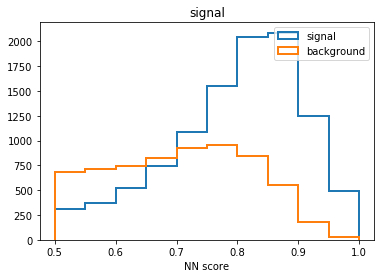

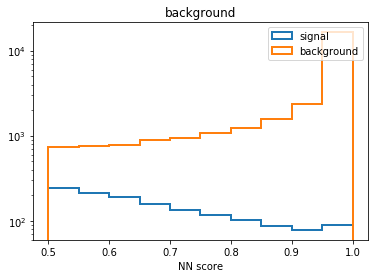

In [11]:
def plot(label, logscale=False):
    category = categories[label]
    plt.figure()
    bins = np.linspace(0.33, 1.0, 10)
    for process in category:
        plt.hist(
            np.array(category[process]["scores"]),
            weights=np.array(category[process]["weights"]),
            #bins=bins,
            histtype="step",
            lw=2,
            label=process)
    plt.title(label)
    plt.xlabel("NN score")
    #plt.xlim((bins[0], bins[-1]))
    if logscale:
        plt.yscale("log")
    plt.legend()
    
# Plot categories
plot("signal")#, logscale=True)
plot("background", logscale=True)

In [12]:
model.save('NN.h5')
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights('NN_weights.h5')

In [13]:
from keras.models import load_model
import numpy as np
model = load_model('NNtf.h5')
#pred = [[38.902351, 30.035307, 2.589421, 0.638355, 20.325911, 89.910355, 0.622604, 0.019863]]
pred = [[85.433296, 43.545998, 2.442940, 0.403881, 14.301805, 135.165955, 49.902340, 3.093282]]
prediction = model.predict(np.array(pred)) 
print prediction

[[0.930268   0.06973198]]
